1. x Benchmark Events
-  x Auswahleverteilung iN und hN darstellen für val, Validation und Test daten
2. x RMSE, MSE und MAE für val, Val und Test vergleichen
3. x Verteilung für alle ergebnisse
- Boxplot oder Violinenplot
-> schein nicht viel sinn zu machen, da zu viele datenpunkte
4. x Actual vs Fitted
5. x (evtl Residuals vs Fitted) könnte nützlich sein um zu schauen bei welchen Wertebereichen welche tendenz besteht
5. MSE der Maximalwerte jedes Ereignisses aus Testdatensatz
- (Zeitliche Verschiebung des Maximalwertes)
6. x Stichproben Plots von Maximalwerten 


In [1]:

# Load Relevant Libraries, the model and the test data
import matplotlib.pyplot as plt
from matplotlib import pyplot
import numpy as np
import pandas as pd
from tensorflow.keras.models import model_from_json
import joblib
import pickle
import os
import seaborn as sns
from modules.sequence_and_normalize import sequence_data, sequence_sample_random, sequence_list
from sklearn.preprocessing import MinMaxScaler
from modules.plots import plot_seq_i_d_Q
from modules.save_load_model import load_model, load_model_container
from modules.predict_and_prepare import pred_inverse_all
from modules.eval_helpers import rmse_from_raw, mae_from_raw, mae_mse_rmse


model_names = ['Gievenbeck_LSTM_Single_1h_P_20240408', 'Gievenbeck_Deep_LSTM_Single_1h_P_20240418']
models = []
for model_name in model_names:
    model_folder = os.path.join('05_models', model_name)
    models.append(load_model_container(model_folder))


# # Load the model
# model_name_1 = 'Gievenbeck_Deep_LSTM_Single_1h_P_20240418'
# model_folder_1 = os.path.join('05_models', model_name_1)
# # model_folder = os.path.join('05_models', 'Gievenbeck_SingleNode_LSTM_20240328')
# model, in_scaler, out_scaler, train_data, val_data, test_data, data_info_dict = load_model(model_folder_1)



c:\Users\fl-al\.conda\envs\ml\Lib\site-packages\sklearn\base.py:318: UserWarning: Trying to unpickle estimator MinMaxScaler from version 1.4.2 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\fl-al\.conda\envs\ml\Lib\site-packages\sklearn\base.py:318: UserWarning: Trying to unpickle estimator MinMaxScaler from version 1.4.2 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Loaded model from disk
Loaded model from disk


In [2]:
# Load events data
# events_df = pd.read_csv('02_input_data/events_FMO.csv')

# sequence data to list structure
for m in models:
    model = m['model']
    lag = m['lag']
    delay = m['delay']
    p_steps = m['prediction_steps']
    in_vars = m['in_vars']
    out_vars = m['out_vars']
    test_data = m['test_data']
    train_data = m['train_data']
    val_data = m['validation_data']
    in_scaler = m['in_scaler']
    out_scaler = m['out_scaler']

    seq_test, seq_test_trans = sequence_list(test_data, in_vars=in_vars, out_vars=out_vars, in_scaler=in_scaler, 
                                    out_scaler=out_scaler, lag=lag, delay=delay, prediction_steps=p_steps)

    train_true, train_pred = pred_inverse_all(train_data, model, in_vars, out_vars, in_scaler, out_scaler, lag, delay, p_steps)
    val_true, val_pred = pred_inverse_all(val_data, model, in_vars, out_vars, in_scaler, out_scaler, lag, delay, p_steps)
    test_true, test_pred = pred_inverse_all(test_data, model, in_vars, out_vars, in_scaler, out_scaler, lag, delay, p_steps)
    
    train_resid = train_true - train_pred
    val_resid = val_true - val_pred
    test_resid = test_true - test_pred
    train_resid = train_resid.flatten()
    val_resid = val_resid.flatten()
    test_resid = test_resid.flatten()

    train_eval = mae_mse_rmse(train_true, train_pred)
    val_eval = mae_mse_rmse(val_true, val_pred)
    test_eval = mae_mse_rmse(test_true, test_pred)
    
    m.update({'seq_test':seq_test, 'seq_test_trans':seq_test_trans,
                    'train_true':train_true, 'train_pred':train_pred, 'val_true':val_true, 
                    'val_pred':val_pred, 'test_true':test_true, 'test_pred':test_pred,
                    'train_resid':train_resid, 'val_resid':val_resid, 'test_resid':test_resid,
                    'train_eval':train_eval, 'val_eval':val_eval, 'test_eval':test_eval})


595/595 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
595/595 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step
171/171 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step


In [13]:
# Print all Event meta data 
# i=0
# for obj in seq_test_trans:
#     print(i, obj[0])
#     i += 1


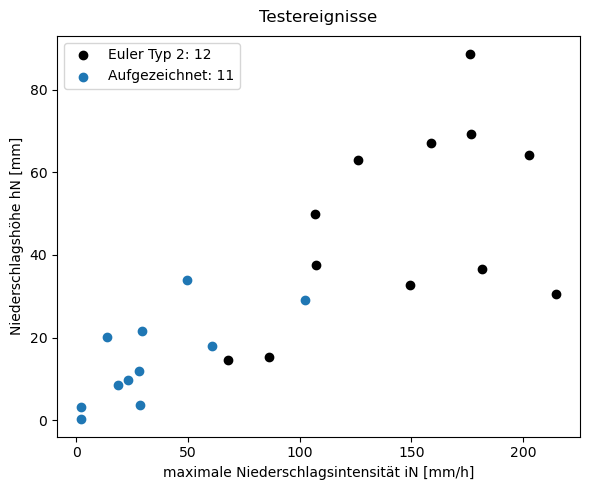

In [3]:
# Extract total precipitation and max intensity from seq_test
seq_test_trans = models[0]['seq_test_trans']
e2_precipitation = [obj[0]['total precipitation'] for obj in seq_test_trans if obj[0]['event type'] == 'Euler Typ 2']
e2_intensity = [obj[0]['max intensity'] for obj in seq_test_trans if obj[0]['event type'] == 'Euler Typ 2']

aufgezeichnet_precipitation = [obj[0]['total precipitation'] for obj in seq_test_trans if obj[0]['event type'] == 'Aufgezeichnet']
aufgezeichnet_intensity = [obj[0]['max intensity'] for obj in seq_test_trans if obj[0]['event type'] == 'Aufgezeichnet']

# Plot events precipitation and intensity in scatterplot
fig, ax2 = plt.subplots(figsize=(6, 5))
ax2.plot( e2_intensity, e2_precipitation,'o', color='black', label='Sample')
ax2.scatter(aufgezeichnet_intensity, aufgezeichnet_precipitation, marker='o',  label='Events')
ax2.set_xlabel('maximale Niederschlagsintensität iN [mm/h]')
ax2.set_ylabel('Niederschlagshöhe hN [mm]')
ax2.set_title('Testereignisse', pad=10)
ax2.legend(labels=['Euler Typ 2: {}'.format(len(e2_precipitation)), 'Aufgezeichnet: {}'.format(len(aufgezeichnet_precipitation))])
plt.tight_layout()


In [15]:
# in_col=1
# out_col=2
# # Keep track of original shapes of in and out data
# in_original_shape = [sample[in_col].shape for sample in seq_test]  
# in_concat = np.concatenate([np.array(sample[in_col]) for sample in seq_test])
# in_concat = np.concatenate([np.array(sequence) for sequence in in_concat])
# # in_concat_flattened = np.reshape(in_concat, (in_concat.shape[0], -1, in_concat.shape[2]))

# out_original_shape = [sample[out_col].shape for sample in seq_test]

# out_concat = np.concatenate([sample[2].reshape(sample[2].shape[0], -1) for sample in seq_test])

# # out_concat = np.concatenate([np.array(sample[out_col]) for sample in seq_test])

# print(in_concat)

# in_invert = in_scaler.inverse_transform(in_concat)
# out_invert = out_scaler.inverse_transform(out_concat)



In [16]:
# # Reshape in_concat back to original shape
# in_invert = np.split(in_concat, np.cumsum([np.prod(shape) for shape in in_original_shape[:-1]]))
# in_invert = [sample.reshape(shape) for sample, shape in zip(in_invert, in_original_shape)]


# # Reshape out_concat back to original shape
# out_invert = np.split(out_concat, np.cumsum([np.prod(shape) for shape in out_original_shape[:-1]]))
# out_invert = [sample.reshape(shape) for sample, shape in zip(out_invert, out_original_shape)]

# seq_test_invert = [(seq_test[i][0], in_invert[i], out_invert[i]) for i in range(len(seq_test))]

# # # Check if the sum of the columns is the same to verify reshaping works properly
# # col_1_sum_seq_test_invert = sum([np.sum(sample[1]) for sample in seq_test_invert])
# # col_1_sum_seq_test = sum([np.sum(sample[1]) for sample in seq_test])
# # col_2_sum_seq_test_invert = sum([np.sum(sample[2]) for sample in seq_test_invert])
# # col_2_sum_seq_test = sum([np.sum(sample[2]) for sample in seq_test])
# # is_same_sum = col_1_sum_seq_test_invert == col_1_sum_seq_test
# # is_same_sum_2 = col_2_sum_seq_test_invert == col_2_sum_seq_test
# # print(is_same_sum, is_same_sum_2)


In [24]:
rmse = pd.DataFrame(columns=['Modell','train', 'val', 'test'])
for m in models:
    name = m['name']
    train_rmse = m['train_eval'][2]
    val_rmse = m['val_eval'][2]
    test_rmse = m['test_eval'][2]
    new_row = pd.DataFrame({'Modell':name,'train': train_rmse, 'val': val_rmse, 'test': test_rmse}, index=[0])
    rmse = pd.concat([rmse, pd.DataFrame(new_row)] , ignore_index=True)

rmse

C:\Users\fl-al\AppData\Local\Temp\ipykernel_14116\1765100998.py:8: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  rmse = pd.concat([rmse, pd.DataFrame(new_row)] , ignore_index=True)


,Modell,train,val,test
0,Gievenbeck_LSTM_Single_1h_P_20240408,0.092812,0.088708,0.103104
1,Gievenbeck_Deep_LSTM_Single_1h_P_20240418,0.040098,0.038370,0.041943


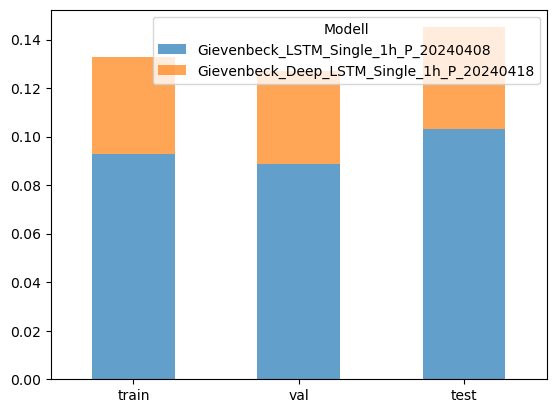

In [25]:
ax = rmse.set_index('Modell').T.plot.bar(alpha=.7, rot=0, stacked=True)

# # Bar plot
# plt.title('Vergleich RMSE', pad=10)
# plt.bar(['Training', 'Validierung', 'Test'], rmse)
# plt.ylabel('Wurzel der mittleren Fehlerquadratsumme - RMSE [-]')

#     # Show the plot
plt.show()

595/595 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
[0.00802346 0.0084469  0.00904785]


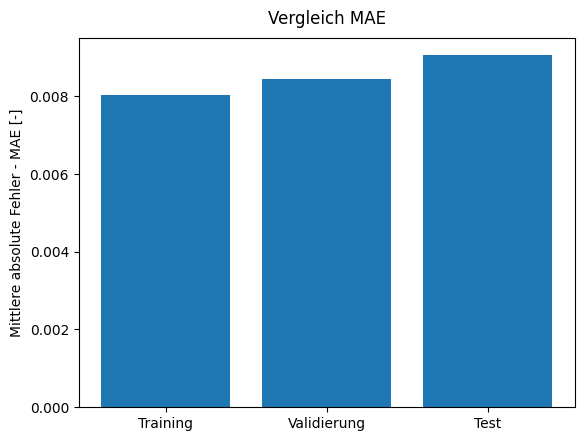

In [18]:
print(mae)
# Bar plot
plt.title('Vergleich MAE', pad=10)
plt.bar(['Training', 'Validierung', 'Test'], mae)
plt.ylabel('Mittlere absolute Fehler - MAE [-]')

# Show the plot
plt.show()

- Density plot - abhängigkeit von input daten wird hier wahrscheinlich weniger sichtbar
- 

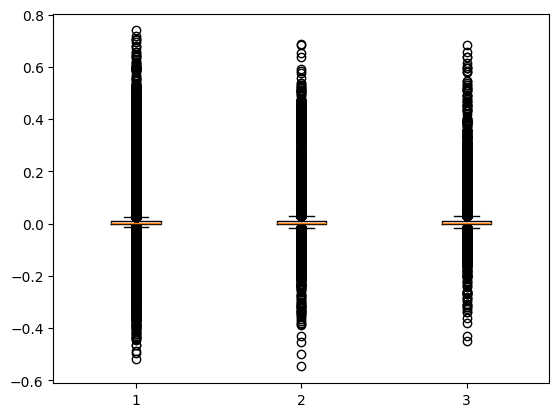

In [19]:

resid = [train_resid, val_resid, test_resid]

plt.boxplot(resid)

# Display the plot
plt.show()

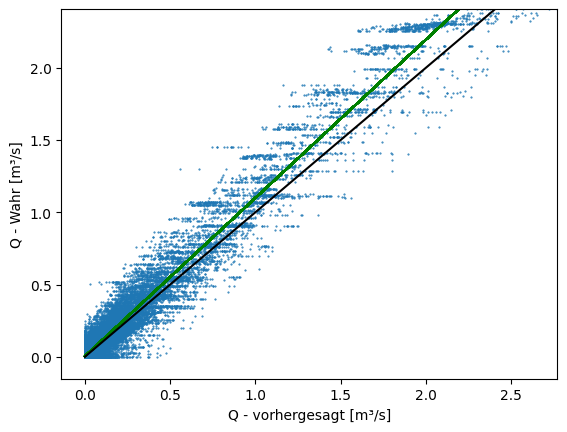

In [20]:
# Flatten the data
train_pred_flat = train_pred.flatten()
train_true_flat = train_true.flatten()

# Plot the data
plt.plot(train_pred_flat, train_true_flat, '.', markersize=1,  label='Train')

# Fit a line to the data
slope, intercept = np.polyfit(train_pred_flat, train_true_flat, 1)

# Plot the fitted line
plt.plot(train_pred_flat, slope * train_pred_flat + intercept, color='green')

# Set the upper limit of the y-axis to the maximum value of each variable
plt.ylim(None, max(train_true_flat))
plt.xlim(None, max(train_pred_flat))
# Draw a line with incline of 1
plt.plot([0, max(train_true_flat)], [0, max(train_true_flat)], color='black')

plt.xlabel('Q - vorhergesagt [m³/s]')
plt.ylabel('Q - Wahr [m³/s]')
plt.show()

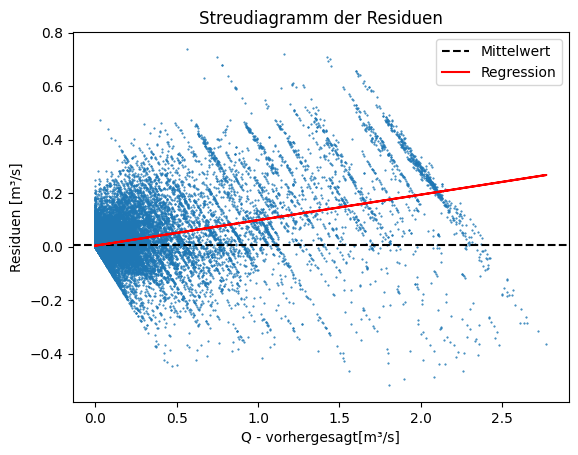

In [21]:

# Calculate the average line
avg_line = np.mean(train_resid)

# Calculate the regression line using polynomial fit
reg_line = np.polyfit(train_pred_flat, train_resid, 1)
reg_line_fn = np.poly1d(reg_line)

# Create the scatter plot
plt.plot(train_pred_flat, train_resid, '.', markersize=1)

# Plot the average line
plt.axhline(avg_line, color='black', linestyle='--', label='Mittelwert')

# Plot the regression line
plt.plot(train_pred_flat, reg_line_fn(train_pred_flat), color='red', label='Regression')

# Set the labels and title
plt.xlabel('Q - vorhergesagt[m³/s]')
plt.ylabel('Residuen [m³/s]')
plt.title('Streudiagramm der Residuen')

# Add a legend
plt.legend()

# Show the plot
plt.show()


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


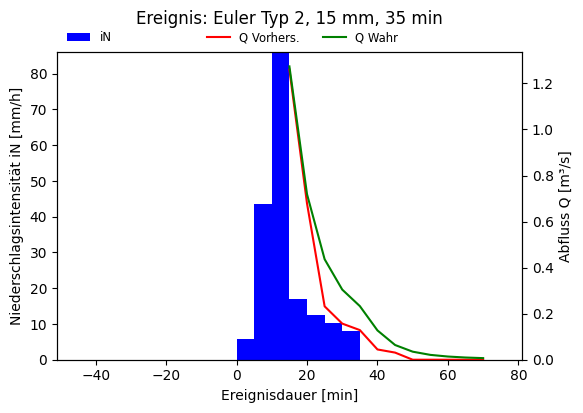

In [22]:
# test for plot_seq_i_d_Q function
n_sample = 3
n = 15
interval = seq_test[n_sample][0]['interval']
meta = seq_test[n_sample][0]
in_seq = seq_test[n_sample][1][n]
out_act = seq_test[n_sample][2][n]

# Calculate the start and end time of the sequence so that a duration column can be created
start_time = max(seq_test[n_sample][1][n][:, 0]) + interval + delay * interval
end_time = start_time + p_steps * interval
duration_col = np.arange(start_time, end_time, interval)

Predict = m.predict(seq_test_trans[n_sample][1])
Predict_invert = out_scaler.inverse_transform(Predict)

predict_seq = np.column_stack((duration_col,Predict_invert[n]))
actual_seq = np.column_stack((duration_col,out_act))


plot_seq_i_d_Q(in_seq, actual_seq, predict_seq, meta, interval,).show()

In [11]:
len(seq_test[3][1]) * 5 - 240
# max_index

30

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 574ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 512ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 330ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 335ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 325ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 474ms/step


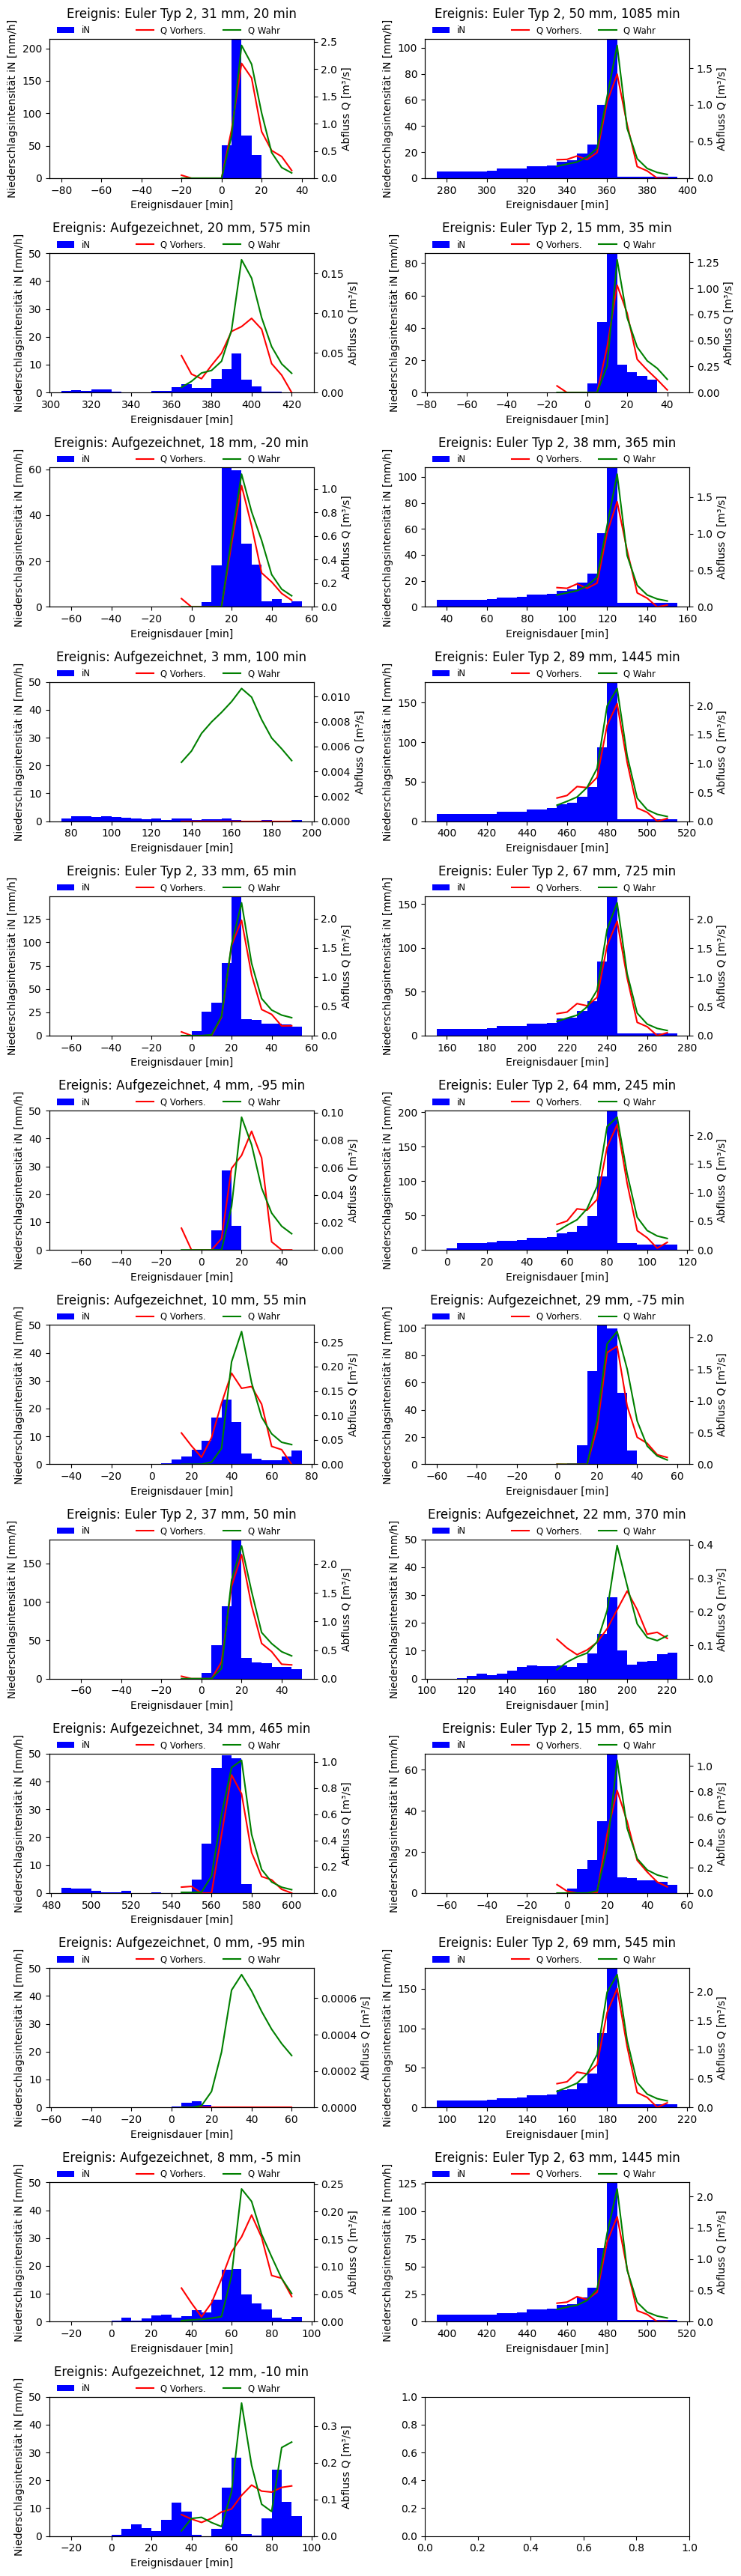

In [23]:
# make this a function that takes event_data =seq_test[n_sample], event_data_trans, n_seq = n,  interval, delay, p_steps, duration_col

# Specify what the column index of the duration data in the input data is
# duration_col = int(0)
#retrieve the interval of the time steps
interval = seq_test[0][0]['interval']  

# Create a grid of subplots
plot_rows = int(len(seq_test_trans)/2+1)
fig, axs = plt.subplots(plot_rows, 2, figsize=(10, 1.5*len(seq_test_trans)))

# Loop through n_sample
for n_sample in range(len(seq_test_trans)):
    # n = 12 +int((len(seq_test[n_sample][1])-24) / 3)
    # n = int(len(seq_test[n_sample][1]) / 5)
    n = np.argmax(seq_test[n_sample][2][:, 0, 0])
    n = n - p_steps/2
    n = n.astype(int)

    # Calculate the start and end time of the sequence so that a duration column can be created
    start_time = max(seq_test[n_sample][1][n][:, 0]) + interval + delay * interval
    end_time = start_time + p_steps * interval
    duration_col = np.arange(start_time, end_time, interval)

    Predict = m.predict(seq_test_trans[n_sample][1])
    Predict_invert = out_scaler.inverse_transform(Predict)
        
    predict_seq = np.column_stack((duration_col,Predict_invert[n]))
    actual_seq = np.column_stack((duration_col,seq_test[n_sample][2][n]))
    
    ''' 
    To do: - why is precipitation always min 1??
    '''
    
    # Dictionary of event meta data
    meta = seq_test[n_sample][0] #'name': sample_name, 'duration': event_duration, 'total precipitation': precip_sum, 'max intensity': max_intensity, 'interval': intervall, 'Ereignis': type


    # Calculate column index for the subplot. Only important for plot!!
    col_index = n_sample % 2

    
    # Create Barplot of Precipitation
    ax1 = axs[n_sample // 2, col_index]
    ax1.set_title(f"Ereignis: {meta['event type']}, {round(meta['total precipitation'])} mm, {meta['duration']} min", pad=20)
    x = seq_test[n_sample][1][n][:,0]  # Set x-axis values
    ax1.bar(x, seq_test[n_sample][1][n][:,1], color='blue', label='iN', width=interval, align='edge')
    top_lim = max(max(seq_test[n_sample][1][n][:,1]), 50)
    ax1.set_ylim(bottom=0, top=top_lim)  # Set y-axis to start from zero
    ax1.set_ylabel('Niederschlagsintensität iN [mm/h]')
    ax1.set_xlabel('Ereignisdauer [min]')
    ax1.legend(loc='upper left', bbox_to_anchor=(0, 1.15), frameon=False, fontsize = 'small')

    # Create a twin axis on the right side
    # Plotting the predicted and actual values in the corresponding subplot
    ax2 = ax1.twinx()
    ax2.plot(predict_seq[:, 0], predict_seq[:, 1], color = 'red', label='Q Vorhers.')
    ax2.plot(actual_seq[:, 0], actual_seq[:, 1], color = 'green', label='Q Wahr')
    ax2.set_ylim(bottom=0)  # Set y-axis to start from zero
    ax2.set_ylabel('Abfluss Q [m³/s]')
    ax2.legend(loc='upper left', bbox_to_anchor=(0.3,1.15), frameon=False, ncol = 2, fontsize = 'small')


    # ax2.legend(loc=1, borderaxespad=1.)
    # ax2.add_artist(legend_1)


plt.tight_layout()
# Show the plot
plt.show()
